In [82]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
import os.path
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from pandas.tseries.offsets import MonthEnd

In [2]:
def calc_intra_annual(df, mean_col, min_col=None, max_col=None, v=False):
    df["DAY"] = df.index.dayofyear
    # next we need to eliminate Feb 29th: 
    df["DAY"] = np.where(df.index.is_leap_year & (df.index.month > 2), df["DAY"] - 1, df["DAY"])  # we just ignore the existence of 29th Feb
    # display(df.loc[(df["DAY"] > 59) & (df["DAY"] <= 61)])
    
    params = ["mean", "std"]
    col_dict = {mean_col: params}
    if min_col is None:
        params.append("min")
    else:
        col_dict[min_col] = "min"
    if max_col is None:
        params.append("max")
    else:
        col_dict[max_col] = "max"
    
    out_df = df.groupby("DAY").agg(col_dict)
    out_df.columns = ("mean", "std", "min", "max")  # "flattens" grouped columns

    out_df["upper"] = out_df["mean"] + out_df["std"]
    out_df["lower"] = out_df["mean"] - out_df["std"]
    
    # checking if the upper and lower values are within max-min limits:
    out_df["upper"] = np.where(out_df["upper"] > out_df["max"], out_df["max"], out_df["upper"])
    out_df["lower"] = np.where(out_df["lower"] < out_df["min"], out_df["min"], out_df["lower"])
    if v:
        display(out_df)
    return out_df


def plot_intra_annual(df, ax):
    ax.fill_between(df.index, df["upper"], df["lower"], color="lightgrey")
    ax.plot(df.index, df["max"], color="grey", linewidth=1)
    ax.plot(df.index, df["min"], color="grey", linewidth=1)
    ax.plot(df.index, df["mean"], color="k", linewidth=1)

    
def mark_axes(ax_tuple, px=-0.1, py=1.15):
    letter = "a"
    for ax in ax_tuple:
        ax.text(px, py, "(%s)" % letter, transform=ax.transAxes, fontsize=MEDIUM_SIZE, va='top', ha='right')
        letter = chr(ord(letter) + 1)  # increments the letter in alphabetical order

        
def monthly_ticks(ax, crop=False):
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))  # 16 is a slight approximation since months differ in number of days

    ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment("center")
    ax.xaxis.get_minor_ticks()[-1].set_visible(False)
    if crop:
        ax.xaxis.get_minor_ticks()[0].set_visible(False)


In [3]:
in_file = "/home/tepex/PycharmProjects/Barentsburg-meteo-plots/data/wr94019.csv"

tmp = pd.read_csv(in_file, comment="#", parse_dates= {"DATE" : ["YEAR","MONTH","DAY"]})
tmp.set_index("DATE", inplace=True)
tmp.info()
# display(tmp)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32508 entries, 1932-01-01 to 2020-12-31
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   WMO_ID         32508 non-null  int64  
 1   MIN_AIR_TEMP   29279 non-null  float64
 2   MEAN_AIR_TEMP  29298 non-null  float64
 3   MAX_AIR_TEMP   29279 non-null  float64
 4   PRECIPITATION  29342 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.5 MB


In [4]:
cm = 1 / 2.54  # inches to cm
wu = 8.5*cm  # width unit
hu = 6*cm  # height unit

LEAST_SIZE = 7
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

matplotlib.rc('font', size=SMALL_SIZE)          # controls default text sizes
matplotlib.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=LEAST_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Data availability plot:

<ipython-input-5-0e8b4bf93590>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_yticklabels(labels);


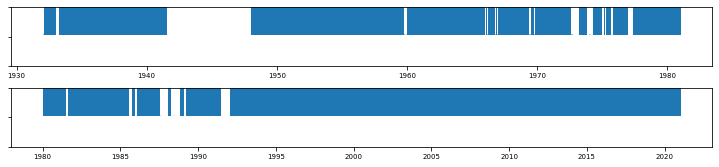

In [5]:
tmp["VALID"] = np.where(pd.isna(tmp["MEAN_AIR_TEMP"]), np.nan, 1)
tmp["NA"] = np.where(pd.isna(tmp["MEAN_AIR_TEMP"]), 1, np.nan)
# display(df)
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(3*wu, 1*hu)

width = 1
height = 1500
verts = list(zip([-width,width,width,-width],[-height,-height,height,height]))

df = tmp
ax[0].scatter(df.loc[df.index.year <= 1980].index, df.loc[df.index.year <= 1980]["VALID"], marker=verts, s=3000)
ax[0].scatter(df.loc[df.index.year <= 1980].index, df.loc[df.index.year <= 1980]["NA"], marker=verts, s=3000, color="white")
ax[1].scatter(df.loc[df.index.year >= 1980].index, df.loc[df.index.year >= 1980]["VALID"], marker=verts, s=3000)
ax[1].scatter(df.loc[df.index.year >= 1980].index, df.loc[df.index.year >= 1980]["NA"], marker=verts, s=3000, color="white")
for a in ax:
    a.set_ylim(0, 1)
    labels = ["", "", ""]
    a.set_yticklabels(labels);
fig.tight_layout()

### Intra-annual variability of the air temperature (XXI century)

<ipython-input-2-1fdc7b0e2bd8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DAY"] = df.index.dayofyear
<ipython-input-2-1fdc7b0e2bd8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DAY"] = np.where(df.index.is_leap_year & (df.index.month > 2), df["DAY"] - 1, df["DAY"])  # we just ignore the existence of 29th Feb


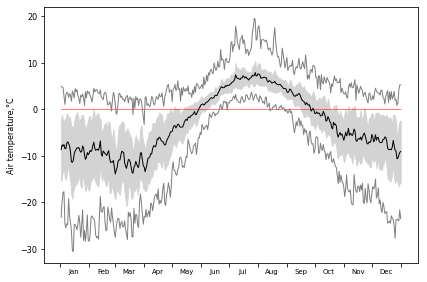

In [6]:
df = tmp.loc[tmp.index.year > 2000]
df = calc_intra_annual(df, "MEAN_AIR_TEMP", min_col="MIN_AIR_TEMP", max_col="MAX_AIR_TEMP")
fig, ax = plt.subplots()
fig.set_size_inches(2*wu, 2*hu)
plot_intra_annual(df, ax)
ax.hlines(y=0, xmin=1, xmax=365, linewidth=0.5, color='r')
ax.set_ylabel("Air temperature,°C")
monthly_ticks(ax, crop=True)

### Monthly precipitation amounts:

This plot is not very informative for mass balance studies.

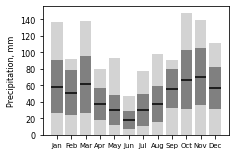

In [111]:
df = tmp.loc[tmp.index.year > 2000]
df = df.resample("M").agg({"MIN_AIR_TEMP": np.min, "MAX_AIR_TEMP": np.max, "MEAN_AIR_TEMP": np.mean, "PRECIPITATION": np.sum})

mean = df.groupby(df.index.month)["PRECIPITATION"].agg("mean")
# display(mean)

std = df.groupby(df.index.month)["PRECIPITATION"].agg("std")
# display(std)

maxes = df.groupby(df.index.month)["PRECIPITATION"].agg("max")
# display(maxes)

fig, ax = plt.subplots()
fig.set_size_inches(1*wu, 1*hu)
bars = ax.bar(maxes.index, maxes, color="lightgrey")
ax.bar(std.index, std * 2, bottom=mean-std, color="grey")
x_start = np.array([plt.getp(item, 'x') for item in bars])
x_end   = x_start + [plt.getp(item, 'width') for item in bars]
plt.hlines(mean, x_start, x_end, color="k")

ax.xaxis.set_ticks(np.arange(1, 13, 1))
labels = ax.get_xticks()
labels = [date(1900, x, 1).strftime('%b') for x in labels]
ax.set_xticklabels(labels)
ax.set_ylabel("Precipitation, mm");

<ipython-input-109-6e8bcbfa56da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["LIQUID"] = np.where(df["MEAN_AIR_TEMP"] >= 0, df["PRECIPITATION"], np.nan)
<ipython-input-109-6e8bcbfa56da>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SOLID"] = np.where(df["MEAN_AIR_TEMP"] < 0, df["PRECIPITATION"], np.nan)


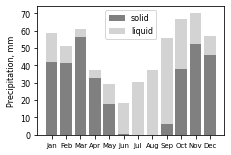

In [109]:
df = tmp.loc[tmp.index.year > 2000]

df["LIQUID"] = np.where(df["MEAN_AIR_TEMP"] >= 0, df["PRECIPITATION"], np.nan)
df["SOLID"] = np.where(df["MEAN_AIR_TEMP"] < 0, df["PRECIPITATION"], np.nan)

df = df.resample("M").agg({"LIQUID": np.sum, "SOLID": np.sum})
solid = df.groupby(df.index.month)["SOLID"].agg("mean")
# print(solid)
liquid = df.groupby(df.index.month)["LIQUID"].agg("mean")
# print(liquid)

fig, ax = plt.subplots()
fig.set_size_inches(1*wu, 1*hu)
ax.bar(solid.index, solid, color="grey", label="solid")
ax.bar(liquid.index, liquid, bottom=solid, color="lightgrey", label="liquid")
ax.legend()

ax.xaxis.set_ticks(np.arange(1, 13, 1))
labels = ax.get_xticks()
labels = [date(1900, x, 1).strftime('%b') for x in labels]
ax.set_xticklabels(labels)
ax.set_ylabel("Precipitation, mm");